<a href="https://colab.research.google.com/github/mwvgroup/Pitt-Google-Broker/blob/u%2Ftjr%2Ftutorials/pgb_utils/tutorials/PGB_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitt-Google Broker
---

# Notebook Outline

1. Use Cases
2. Overview: Data storage and access
3. Setup
    - 
4. Access: Databases
    - Get object histories and lightcurves
    - 



`pgb_utils` is a collection of helper functions for accessing, reading, and processing 

# 1) Use cases

| Use Case or Task | Section |
|---|---|
|1. found an object(s) and you want to get it's history | query db, section 3 |
|2. ~found an object, want to know it's future~ we're not ready |~pubsub~ either a watchlist or model predictions (which Alerce is now doing).|

3. You have found a small group of objects you want to study
    - [sec 
    - you come up with a model and want to look for other objects that are similar: sec 7, use a Beam pipeline to query the db and analyze the results.
    - you refine your model and want to monitor the alert stream for new objects displying similar behavior: sec 7 the Pub/Sub streams 
- don't know the object your looking for. want to do exploration/discover. do the query, then convert to pubsub streams.
    - found 10 91-bg's, found particular type of rise behavior. query db, which 
- michael, statistics on all data.

1. past
2. future
- convert past to future





# 2) Overview: Data storage and access

- Databases are stored in [BigQuery](https://cloud.google.com/bigquery) and can be queried via the command-line, Python and other languages.
- Alert Avro files are stored in [Cloud Storage](https://cloud.google.com/storage) and can be accessed via the command-line, Python and other languages.
- Live alert streams are delivered via [Pub/Sub](https://cloud.google.com/pubsub/docs/overview) and can be accessed via Python.

Specifics (e.g., schemas) are detailed in the relevant sections.

Our data and services are public. You do not need special access or configuration files from us, but you will need an account on [Google Cloud Platform](https://cloud.google.com/gcp) and you must authenticate yourself to access anything in Google Cloud. The Setup section of this tutorial includes directions for doing this.

Google provides command-line tools and APIs  in [Python](https://cloud.google.com/python/references/libraries), etc., which you can use to access our data and services.

In addition, we have written a package of Python utilities, `pgb_utils`, which are a collection wrappers for Google's Python API tools and helper functions that give you some options for reading and process the data.
 
Links to more information:
- Working with ZTF alerts: [Filtering_alerts.ipynb](https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb)

---

# 3) Setup

- Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to Create a Cloud Platform project if you do not already have one.
- [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for your project
- Enable APIs for your project:
    - [BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery)

Note: This notebook is intended to run in Google Colab which: 
1. provides an environment pre-configured with most of the libraries we need, and
2. facilitates authentication, avoiding the need to download and configure credentials.

(I should provide users with a little more info about how to connect outside of this notebook.)

In [1]:
from matplotlib import pyplot as plt
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage
from google.colab import auth
from google.colab import drive


In [4]:
#--- Colab Setup
auth.authenticate_user()  # follow the instructions to authorize Google Cloud SDK 


#--- Local machine setup
# [to do]

In [5]:
# Create a function to run and print a shell command.
def run(cmd: str):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

In [6]:
# Install apache-beam.
run('pip install --quiet apache-beam')
run('pip install google-apitools')

>> pip install --quiet apache-beam
     |████████████████████████████████| 9.0MB 5.6MB/s 
     |████████████████████████████████| 153kB 53.0MB/s 
     |████████████████████████████████| 829kB 37.4MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 2.2MB 50.0MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 17.7MB 205kB/s 
     |████████████████████████████████| 112kB 39.2MB/s 
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.

>> pip install google-apitools
     |████████████████████████████████| 174kB 6.0MB/s 
  Created wheel for google-apitools: filename=google_apitools-0.5.31-cp37-none-any.whl size=131043 s

In [7]:
# Install the Pitt-Google Broker utilities package
run('python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils')

# This is currently on the test.pypi servers. I should publish to the actual
# PyPI soon, but I'd like some code review first.

# I have termporarily named this `pgb_utils`, but we should decide on something.

>> python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils
Looking in indexes: https://test.pypi.org/simple/



In [8]:
import pgb_utils as pgb

my_project_id = 'ardent-cycling-243415'  # *
pgb_project_id = 'ardent-cycling-243415'

# *This notebook is written to take an arbitrary GCP project ID, 
# but I haven't tested it and I don't think the BigQuery tables are even
# configured for that yet.

In [3]:
# Connect your Google Drive file system
# (this is only needed for the section on Apache Beam pipelines)
drive.mount('/content/drive')  # follow the instructions to authorize access
colabpath = '/content/drive/MyDrive/Colab\ Notebooks'
colabpath4beam = '/content/drive/MyDrive/Colab Notebooks'

# Hint: Click the "Files" icon on the left to view a file browser.
# Hint: Click the "Code snippets" icon (<>) on the left and search for 
#       "access drive" to learn how to interact with Drive.

Mounted at /content/drive


---

# 4) Access: Databases

We currently have the following database tables available to query (format: `dataset.table`):
- `ztf_alerts.alerts`
-`ztf_alerts.salt2`

They are stored in [BigQuery](https://cloud.google.com/bigquery) and contain data since ~Nov 2020.
Their schemas can be viewed using the code below. 
They can be queried using standard SQL from the command-line, Python, Java and other languages, as well as from the [Console](https://console.cloud.google.com).
In this tutorial, we will demonstrate the following methods: 1) Python, including `pgb_utils` tools that facilitate access, and 2) command-line. 

Links to more information:
- [Overview of querying BigQuery data](https://cloud.google.com/bigquery/docs/query-overview)


- [BigQuery How-to guides](https://cloud.google.com/bigquery/docs/how-to). There are many! Here are some of note:

    - [Introduction to interacting with BigQuery](https://cloud.google.com/bigquery/docs/interacting-with-bigquery)

    - [Queries](https://cloud.google.com/bigquery/docs/running-queries) (this topic is covered in this tutorial)

    - [Writing query results to your own BigQuery table](https://cloud.google.com/bigquery/docs/writing-results#permanent-table) (also see other sections on that page)

    - [Export table data to a file in Google Cloud Storage](https://cloud.google.com/bigquery/docs/exporting-data)
        - Note the [Exporting data stored in BigQuery](https://cloud.google.com/bigquery/docs/exporting-data#exporting_data_stored_in) section of that page.

    - [Best practices](https://cloud.google.com/bigquery/docs/how-to#best-practices) (e.g., Controlling costs, Optimizing query performance)

- Other Colab tutorials:

    - [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb)

- Pricing:
    - [Overview of BigQuery pricing](https://cloud.google.com/bigquery/pricing)
        - [Query pricing](https://cloud.google.com/bigquery/docs/query-overview#query_pricing)
            - Query charges are based on number of bytes processed.
            - __*The first 1 TB of data processed per month, per billing account, is free*__.
        - [Storage pricing](https://cloud.google.com/bigquery/pricing#storage)
            - The first 10 GB of BigQuery storage per month is free (you only pay for tables you create in your own project).

    - [Using cached query results](https://cloud.google.com/bigquery/docs/cached-results)
        - BigQuery writes all query results to a temporary (~24 hours), cached results table (unless you explicitly specify a destination table). When you run a duplicate query, BigQuery attempts to reuse cached results. If it is successful, you are not charged for the query.

## 4a) Python

<!-- standard SQL default ([change to legacy SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Intro to BigQuery API Client Libraries](https://cloud.google.com/bigquery/docs/reference/libraries) (includes Python, Java, C#, Go, Node.js, PHP, and Ruby)
- [BigQuery Python Client Documentation](https://googleapis.dev/python/bigquery/latest/index.html)
- [Colab Snippets](https://colab.research.google.com/notebooks/snippets/bigquery.ipynb#scrollTo=jl97S3vfNHdz) (more examples)

### 4a.a) View table names and schemas

In [11]:
# Print list of table names and schemas
pgb.bigquery.get_table_info()

ardent-cycling-243415.ztf_alerts.salt2
+----+---------------+---------------+---------+
|    | column_name   | description   | type    |
+====+===============+===============+=========+
|  0 | objectId      |               | STRING  |
+----+---------------+---------------+---------+
|  1 | candid        |               | INTEGER |
+----+---------------+---------------+---------+
|  2 | success       |               | INTEGER |
+----+---------------+---------------+---------+
|  3 | ncall         |               | INTEGER |
+----+---------------+---------------+---------+
|  4 | chisq         |               | FLOAT   |
+----+---------------+---------------+---------+
|  5 | ndof          |               | INTEGER |
+----+---------------+---------------+---------+
|  6 | z             |               | FLOAT   |
+----+---------------+---------------+---------+
|  7 | z_err         |               | FLOAT   |
+----+---------------+---------------+---------+
|  8 | t0            |        

---

### 4a.b) Query [standard SQL + `google.cloud.bigquery`]

Here we demonstrate how to query a database directly using standard SQL and the `google.cloud.bigquery` Python API. 
In the next section we will demonstrate our `pgb.bigquery` module which provides helper functions for common tasks (e.g., querying for lightcurves), many of which are simply convience wrappers for the methods and calls we introduce here.

Links to more information:
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [`google.cloud.bigquery` docs](https://googleapis.dev/python/bigquery/latest/index.html)

Query setup:

In [12]:
# Create a function to execute a "dry run" query 
# and tell us how much data will be processed
def dry_run(query: str):
    """Perform a dry run to find out how many bytes the query will process.
    Args:
        query: SQL query statement
    """
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    query_job = bq_client.query(query, job_config=job_config)

    nbytes, TB = query_job.total_bytes_processed, 1e12
    print(f'\nQuery statement:')
    print(f'\n"{query}"\n')
    print(f'will process {nbytes} bytes of data.')
    print(f'({nbytes/TB*100:.3}% of your 1 TB free monthly allotment.)')

In [13]:
# Create a BigQuery client
bq_client = bigquery.Client(project=my_project_id)

In [14]:
# Write the standard SQL query statement as a string

# View a list of available tables using
# pgb.bigquery.get_dataset_table_names()
# Hint: click "Insert" -> "Scratch code cell" and run this command in the new "Scratch cell"

# View available column names using
# pgb.bigquery.get_table_info(table)

# construct the full table name
dataset = 'ztf_alerts'
table = 'salt2'
full_table_name = f'{pgb_project_id}.{dataset}.{table}'

# construct the query
# Here we query the salt2 database, 
#   group results by objectId,
#   and return the objectId, avg redshift, and average chi squared per degree of freedom
query = (
    f'SELECT objectId, AVG(z) as z_avg, AVG(chisq/ndof) as chisq_per_dof_avg '
    f'FROM `{full_table_name}` '
    f'WHERE ndof>0 and chisq/ndof<2 '
    f'GROUP BY objectId'
)

# Find out how much data will be processed
dry_run(query)


Query statement:

"SELECT objectId, AVG(z) as z_avg, AVG(chisq/ndof) as chisq_per_dof_avg FROM `ardent-cycling-243415.ztf_alerts.salt2` WHERE ndof>0 and chisq/ndof<2 GROUP BY objectId"

will process 4661118 bytes of data.
(0.000466% of your 1 TB free monthly allotment.)


Query:

In [15]:
# Make the API request
query_job = bq_client.query(query)
# Beware: the results may contain duplicate entries

Format and view results:

,objectId,z_avg,chisq_per_dof_avg
0,ZTF20acpwjus,0.125645,0.260774
1,ZTF19aalcuwu,0.088871,1.177646
2,ZTF20aadwhwo,0.123881,0.741822
3,ZTF19abxvtlw,0.105010,0.967316
4,ZTF20acnvfzm,0.160182,0.507394


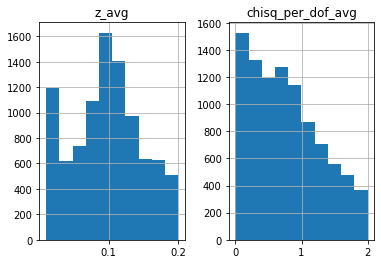

In [16]:
# Option 1: dump results to a pandas.DataFrame
df = query_job.to_dataframe()

# look at some things
df.hist()
df.head()

In [17]:
# Option 2: parse results row by row
for r, row in enumerate(query_job):
    
    # row values can be accessed by field name or index
    print(f"objectId={row[0]}, z_avg={row['z_avg']}")

    if r>5: break

objectId=ZTF20acpwjus, z_avg=0.12564467001350713
objectId=ZTF19aalcuwu, z_avg=0.08887082652554652
objectId=ZTF20aadwhwo, z_avg=0.12388102102402986
objectId=ZTF19abxvtlw, z_avg=0.10501007919822207
objectId=ZTF20acnvfzm, z_avg=0.1601822325649473
objectId=ZTF20actkoic, z_avg=0.1216103844861559
objectId=ZTF19adcbaly, z_avg=0.034705676606653225


---

### 4a.c) Query [`pgb_utils`]

To query the alerts database for an object's _history_, one must group the query results by the `objectId` and aggregate the remaining data.
You can do this yourself using the methods in the previous section, or you can let the `pgb.bigquery` helper functions do some or all of the work for you.

Overview of noteable functions:

In [ ]:
pgb.bigquery.query_objects(columns, objectIds=objectIds)

Query Setup:

In [19]:
# Choose the history data you want returned

# View available column names using
# pgb.bigquery.get_history_column_names()

columns = ['jd', 'fid', 'magpsf', 'sigmapsf']  # some lightcurve info
# 'objectId' and 'candid' will be included automatically

In [20]:
# Optional: Choose the objects you want returned
# If you do not pass an `objectIds` argument to `query_objects()` (below)
# you will get every object in our database.

# choose some objects based on the results of the salt2 query above
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

Query object histories:

In [24]:
# Option 0: Let pgb generate the required SQL statement, 
#           then execute the query yourself using methods from the previous section.

query = pgb.bigquery.object_history_sql_statement(columns, objectIds=objectIds)
print(query)

# dry_run(query)
# query_job = bq_client.query(query)

SELECT objectId, ARRAY_AGG(candid ORDER BY candidate.jd) AS candid, ARRAY_AGG(candidate.jd ORDER BY candidate.jd) AS jd, ARRAY_AGG(candidate.magpsf ORDER BY candidate.jd) AS magpsf, ARRAY_AGG(candidate.fid ORDER BY candidate.jd) AS fid, ARRAY_AGG(candidate.sigmapsf ORDER BY candidate.jd) AS sigmapsf FROM `ardent-cycling-243415.ztf_alerts.alerts` WHERE objectId IN ("ZTF18aczuwfe","ZTF18aczvqcr","ZTF20acqgklx","ZTF18acexdlh") GROUP BY objectId


Note: The first time you query using `pgb_utils` you will be prompted to open a BigQuery Client. 
Enter your project_id in plain text when instructed; do not wrap the id in quotes.

In [25]:
# Option 1: Get a single DataFrame of all results

lcsdf = pgb.bigquery.query_objects(columns, objectIds=objectIds)
# This will execute a dry run and tell you how much data will be processed.
# You will be asked to confirm before proceeding.
# In the future we will skip the dry run and confirmation with `dry_run=False`.

lcsdf.sample(10)
# cleaned of duplicates


Query statement:

"SELECT objectId, ARRAY_AGG(candid ORDER BY candidate.jd) AS candid, ARRAY_AGG(candidate.jd ORDER BY candidate.jd) AS jd, ARRAY_AGG(candidate.magpsf ORDER BY candidate.jd) AS magpsf, ARRAY_AGG(candidate.fid ORDER BY candidate.jd) AS fid, ARRAY_AGG(candidate.sigmapsf ORDER BY candidate.jd) AS sigmapsf FROM `ardent-cycling-243415.ztf_alerts.alerts` WHERE objectId IN ("ZTF18aczuwfe","ZTF18aczvqcr","ZTF20acqgklx","ZTF18acexdlh") GROUP BY objectId"

will process 1425336912 bytes of data.
(0.143% of your 1 TB free monthly allotment.)
Continue? [y/N]: y


jd     magpsf  fid  sigmapsf
objectId     candid                                                     
ZTF18acexdlh 1514253651415015005  2.459269e+06  18.971836    2  0.137007
             1549151215615010007  2.459304e+06  18.831125    2  0.088465
             1462325575615015004  2.459217e+06  19.165098    2  0.141370
ZTF20acqgklx 1438294975215015018  2.459193e+06  19.228207    1  0.191553
ZTF18acexdlh 1450323131415015015  2.459205e+06  19.424927    1  0.159461
             1439302740315010057  2.459194e+06  19.093370    2  0.133488
ZTF20acqgklx 1451204595215015021  2.459206e+06  18.839638    2  0.106252
ZTF18acexdlh 1503213471415010084  2.459258e+06  19.181339    2  0.145436
ZTF18aczvqcr 1410421083615015027  2.459165e+06  20.126310    1  0.147839
ZTF20acqgklx 1440322515215015022  2.459195e+06  19.242628    1  0.108532

In [28]:
# Option 2: Get a generator that yields a DataFrame for each objectId

objects = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     iterator=True,
                                     dry_run=False
                                     )
                                     # cleaned of duplicates

for lcdf in objects:
    print(f'\nobjectId: {lcdf.objectId}')
    print(lcdf.sample(5))

# Help! 
# query_objects() (with these params) returns a GENERATOR EXPRESSION
# which may not be the right way to do this.
# I'm not very familiar with creating generator functions.
# The resulting `objects` generator can only be used once. This was 
# unexpected behavior to me.
# I've also named the keyword "iterator" which might contribute confusion.
# I tried using a yield statement instead, but ran into trouble because I 
# want this function to return something other than a generator when given 
# different params.


objectId: ZTF18aczuwfe
                               jd     magpsf  fid  sigmapsf
candid                                                     
1510148923415015004  2.459265e+06  20.099720    2  0.175255
1469258283415015005  2.459224e+06  20.287066    2  0.212321
1479213073415015001  2.459234e+06  19.893818    2  0.178393
1510206363415015002  2.459265e+06  19.803467    1  0.164810
1451204593415015000  2.459206e+06  20.036793    2  0.181526

objectId: ZTF18aczvqcr
                               jd     magpsf  fid  sigmapsf
candid                                                     
1410421083615015027  2.459165e+06  20.126310    1  0.147839
1469312763615015029  2.459224e+06  19.705523    2  0.122980
1416402323615015029  2.459171e+06  19.717068    2  0.120142
1471254023615015025  2.459226e+06  19.591162    2  0.183519
1416428113615015031  2.459171e+06  20.324043    1  0.213728

objectId: ZTF18acexdlh
                               jd     magpsf  fid  sigmapsf
candid                      

In [29]:
# Option 3: Get a single json string with all the results

lcsjson = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     format='json',
                                     dry_run=False
                                     )
                                     # cleaned of duplicates
print(lcsjson[0:100])

# read it back in
df = pd.read_json(lcsjson)
df.head()

# Help!
# There are many json format options. I haven't worked with json before, so I 
# don't know the best ones to choose. I chose the defaults. The result doesn't 
# look pretty if you print it out, but has the advantage that it reads back
# in to a dataframe nicely.
# BTW, I chose to offer this option in the first place because ALeRCE does it
# and it seemed easy. I don't know how useful it is.

{"objectId":{"0":"ZTF18acexdlh","1":"ZTF18acexdlh","2":"ZTF18acexdlh","3":"ZTF18acexdlh","4":"ZTF18a


,objectId,candid,jd,magpsf,fid,sigmapsf
0,ZTF18acexdlh,1413467435615010006,2.459168e+06,19.826857,2,0.166471
1,ZTF18acexdlh,1413504165615010011,2.459168e+06,19.802505,1,0.198211
2,ZTF18acexdlh,1415503721415015012,2.459170e+06,19.295223,2,0.143628
3,ZTF18acexdlh,1415504180315015015,2.459170e+06,19.323833,2,0.182748
4,ZTF18acexdlh,1436373241415015008,2.459191e+06,19.320747,1,0.173271


In [31]:
# Option 4: Get a generator that yields a json string for a single objectId

jobj = pgb.bigquery.query_objects(columns, 
                                  objectIds=objectIds, 
                                  format='json', 
                                  iterator=True,
                                  dry_run=False
                                  )
                                  # cleaned of duplicates

for lcjson in jobj:
    print(lcjson[0:50])
    # lcdf = pd.read_json(lcjson)  # read back to a df

{"candid":{"0":1414351235215015023,"1":14143659352
       objectId               candid            jd     magpsf  fid  sigmapsf
0  ZTF18acexdlh  1413467435615010006  2.459168e+06  19.826857    2  0.166471
1  ZTF18acexdlh  1413504165615010011  2.459168e+06  19.802505    1  0.198211
2  ZTF18acexdlh  1415503721415015012  2.459170e+06  19.295223    2  0.143628
3  ZTF18acexdlh  1415504180315015015  2.459170e+06  19.323833    2  0.182748
4  ZTF18acexdlh  1436373241415015008  2.459191e+06  19.320747    1  0.173271
{"candid":{"0":1440303993415015003,"1":14403225134
       objectId               candid            jd     magpsf  fid  sigmapsf
0  ZTF18acexdlh  1413467435615010006  2.459168e+06  19.826857    2  0.166471
1  ZTF18acexdlh  1413504165615010011  2.459168e+06  19.802505    1  0.198211
2  ZTF18acexdlh  1415503721415015012  2.459170e+06  19.295223    2  0.143628
3  ZTF18acexdlh  1415504180315015015  2.459170e+06  19.323833    2  0.182748
4  ZTF18acexdlh  1436373241415015008  2.459191e+06 

In [32]:
# Option 5: Get the raw query_job (see previous section) object

query_job = pgb.bigquery.query_objects(columns, 
                                       objectIds=objectIds, 
                                       format='query_job',
                                       dry_run=False
                                       )
# query_job is iterable; each element contains the aggregated history for a single objectId
# Beware: this has not been cleaned of duplicate entries

In [33]:
# Option 5 (continued): parse query_job results row by row

for row in query_job:
    # values can be accessed by field name or index
    print(f"objectId={row[0]}, magpsf={row['magpsf']}")

    # pgb can cast to a DataFrame or json string
    # this also cleans the duplicates
    lcdf = pgb.bigquery.format_history_query_results(row=row)
    print(f'\nobjectId: {lcdf.objectId}')  # objectId in metadata
    print(lcdf.head(1))
    lcjson = pgb.bigquery.format_history_query_results(row=row, format='json')
    print('\n', lcjson[0:100])

    break

objectId=ZTF18aczvqcr, magpsf=[20.126310348510742, 19.64371109008789, 19.71706771850586, 20.32404327392578, 19.552291870117188, 20.146791458129883, 19.952713012695312, 19.952713012695312, 19.403717041015625, 19.403717041015625, 19.54031753540039, 19.54031753540039, 20.161224365234375, 20.161224365234375, 19.499542236328125, 19.690040588378906, 19.648038864135742, 19.705522537231445, 19.591161727905273, 19.856361389160156, 19.771814346313477, 20.00579071044922, 19.85091781616211, 19.847415924072266, 20.478899002075195, 19.79427146911621, 20.005157470703125, 19.90910530090332, 19.76837158203125, 19.721454620361328]

objectId: ZTF18aczvqcr
                               jd    magpsf  fid  sigmapsf
candid                                                    
1410421083615015027  2.459165e+06  20.12631    1  0.147839

 {"candid":{"0":1410421083615015027,"1":1414350743615015012,"2":1416402323615015029,"3":1416428113615


In [34]:
# Option 5 (continued): convert the full query_job to a different format
lcsdf = pgb.bigquery.format_history_query_results(query_job=query_job)
lcsjson = pgb.bigquery.format_history_query_results(query_job=query_job, format='json')

# This is just the long way around to get Options 1 and 3, 
# but we demonstrate it for completeness.

---

#### Plot a lightcurve

`pgb` can plot lightcurves, given a DataFrame with the following columns: `['jd','fid','magpsf','sigmapsf','diffmaglim']`

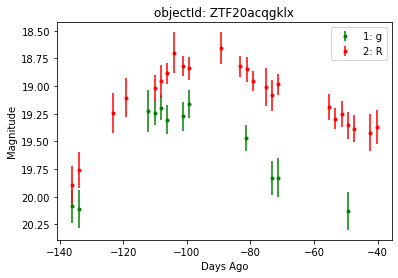

In [35]:
# Get a DataFrame with the required lightcurve data
columns = ['jd','fid','magpsf','sigmapsf','diffmaglim']
objectId = 'ZTF20acqgklx'
lcdf = pgb.bigquery.query_objects(columns, objectIds=[objectId], dry_run=False)

# make the plot
pgb.figures.plot_lightcurve(lcdf, objectId=objectId)
# function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

---

## 3b) Command-line tool `bq`

All commands in this section are executed using the `run` function we created earlier to run commands on the command-line.

`bq`'s default dialect is legacy SQL. Here we use standard SQL by passing `--use_legacy_sql=false`.
<!-- (see [change to standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Quickstart using the bq command-line tool](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-command-line)
- [Reference of all `bq` commands and flags](https://cloud.google.com/bigquery/docs/reference/bq-cli-reference)
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)

In [36]:
# Get help
run('bq help query')

>> bq help query
Python script for interacting with BigQuery.


USAGE: bq.py [--global_flags] <command> [--command_flags] [args]


query                      Execute a query.

                           Query should be specified on command line, or passed
                           on stdin.

                           Examples:
                           bq query 'select count(*) from
                           publicdata:samples.shakespeare'
                           echo 'select count(*) from
                           publicdata:samples.shakespeare' | bq query

                           Usage:
                           query [<sql_query>]

                           Flags for query:

                             /tools/google-cloud-sdk/platform/bq/bq.py:
                               --[no]allow_large_results: Enables larger
                                 destination table sizes for legacy SQL queries.
                               --[no]append_table: When a destination tabl

In [37]:
# view the schema of a table
run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.salt2')
# run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.alerts')

# Note: The first time you make a call with `bq` you will ask you to 
# initialize a .bigqueryrc configuration file. Follow the directions.

>> bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.salt2

Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
[
  {
    "#": 1, 
    "friendlyName": "Budget", 
    "projectId": "budget-242622"
  }, 
  {
    "#": 2, 
    "friendlyName": "Kafka to BigQuery", 
    "projectId": "kafka-to-bigquery"
  }, 
  {
    "#": 3, 
    "friendlyName": "My First Project", 
    "projectId": "smiling-timing-239918"
  }, 
  {
    "#": 4, 
    "friendlyName": "Pitt-Broker", 
    "projectId": "pitt-broker"
  }, 
  {
    "#": 5, 
    "friendlyName": "pitt-google-broker-prototype", 
    "projectId": "ardent-cycling-243415"
  }
]
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a sel

In [38]:
# Query

# Here we query the salt2 database, 
#   group results by objectId,
#   and return the objectId, avg redshift, and average chi squared per degree of freedom

# first we do a dry_run by including the flag --dry_run
bq_query = """bq query \
--dry_run \
--use_legacy_sql=false \
'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId'
"""

run(bq_query)
# Note: to execute this directly in the command-line, enter everything 
# contained within the triple quotes.

>> bq query --dry_run --use_legacy_sql=false 'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId'

Query successfully validated. Assuming the tables are not modified, running this query will process 4661118 bytes of data.



In [39]:
# now let's execute the query

bq_query = """bq query \
--use_legacy_sql=false \
'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId
LIMIT
    10'
"""

run(bq_query)

>> bq query --use_legacy_sql=false 'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId
LIMIT
    10'

Waiting on bqjob_r1c24f758beb1833b_0000017887fc36a8_1 ... (0s) Current status: DONE   
+--------------+---------------------+---------------------+
|   objectId   |        z_avg        |  chisq_per_dof_avg  |
+--------------+---------------------+---------------------+
| ZTF18acedtrr | 0.11041207724930682 |   0.765894240925551 |
| ZTF18acwgwjx |  0.0782981140542461 |  1.2391314442006995 |
| ZTF20acurtpj | 0.07000531275558222 | 0.16031656945872366 |
| ZTF18abuqhmh | 0.08990690410424898 |  0.9928244133196046 |
| ZTF18aczvqcr | 0.15267833194935965 |  0.8574954970959167 |
| ZTF20acpndgt |  0.1034171238925821 | 0.47740791080768413 |
| ZTF18acexfph |  0.0869755266891918 |   1.315439791990906 |
| ZTF18aadvwyz | 0.06711704624315813 | 0.1806005443442384

In [ ]:
# Help!
# Not sure what else to demonstrate here.
# I looked for flags to change the format of the results, but didn't see anything.
# I could show them how to create their own BigQuery table and save the results there.
# I could also show how to create their own Cloud Storage bucket and export an entire table there.

---

# 5) Download a file from Cloud Storage

__This section is not ready for review.__ 

- grab cutouts from Cloud Storage

- [Quickstart: Using the gsutil tool](https://cloud.google.com/storage/docs/quickstart-gsutil)

In [ ]:
#--- Download an alert from GCS bucket

import logging
import os

bucket_name = f'{pgb_project_id}_ztf_alert_avro_bucket'
fname_prefix = '1605062619785'  # recently ingested avro file name, get from logging
local_dir = './testdownload'
delimiter = '/'

storage_client = storage.Client.from_service_account_json('GCPauth_pitt-google-broker-prototype-0679b75dded0.json')
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=fname_prefix, delimiter=delimiter) #List all objects that satisfy the filter.
# Download the file to a destination
# Iterating through for loop one by one using API call
for blob in blobs:
    destination_uri = '{}/{}'.format(local_dir, blob.name)
    blob.download_to_filename(destination_uri)

---

# 6) Listen to Pub/Sub Streams

__This section is not ready for review.__ 

- Python
  - unpack into dict

---

---

# 7) Run an Apache Beam data pipeline to analyze BigQuery or Pub/Sub data

[Apache Beam](https://beam.apache.org/) is an SDK that facilitates writing and executing data pipelines.
The same pipeline can be attached to different sources (e.g., BigQuery and Pub/Sub) and run in batch or streaming mode.
In this tutorial, we will demonstrate these pipelines and the
`pgb_utils` tools that facilitate Beam access to our databases and streams.

We will execute pipelines directly in the notebook, but the same pipelines can be executed on a local machine or various distributed systems using different "runners". 
For example, see 
[Apache Flink](https://beam.apache.org/documentation/runners/flink/), 
[Apache Spark](https://beam.apache.org/documentation/runners/spark/), 
[Google Dataflow](https://beam.apache.org/documentation/runners/dataflow/), and
[DirectRunner](https://beam.apache.org/documentation/runners/direct/) (the last being the default, which we use below).
The user sets a few configurations and the runner manages the pipeline execution and the resources (e.g., VM's) and environments needed to run it.

Links to more information:
- [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/) (very useful!)
- [Colab Snippets: Apache Beam](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-py.ipynb)

<!-- We use the [Apache Beam](https://beam.apache.org/) (Python) SDK to write the data pipeline (see also [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/)). This has the following advantages:

1. Convenience: Native I/O functions for Pub/Sub, BigQuery, and Cloud Storage.
2. Flexiblity: The same pipeline can accept streaming and batch inputs. -> Use the same pipeline to process the live stream and reprocess the database.
3. Portability: The same pipeline can be run/executed in multiple environments (Google Cloud, AWS, local machine) via an execution "runner" ([Apache Flink](https://beam.apache.org/documentation/runners/flink/), [Apache Spark](https://beam.apache.org/documentation/runners/spark/), [Google Dataflow](https://beam.apache.org/documentation/runners/dataflow/), or [direct/local](https://beam.apache.org/documentation/runners/direct/)). -->

In [40]:
import apache_beam as beam
# if you get an error, try again

---

## 7a) Query object histories and run a Beam pipeline on the results

In [41]:
# Define some functions/classes to process our data.
# The structure of these will be discussed later.

# Filter for likely solar system objects
def nearby_ssobject(lcdf):
    """Filter that keeps only objects that are within 5" of a known 
    solar system object. 
    """
    ssdistnr = lcdf['ssdistnr'].mean()
    ssobject_is_near = (ssdistnr > 0) and (ssdistnr < 5)
    return ssobject_is_near


# Calculate the mean magnitude, per passband
class calc_mean_mags(beam.DoFn):
    """Class that wraps our processing function which calculates 
    mean magnitudes per passband ("fid" is filter ID).
    """
    def process(self, lcdf):
        meanmags = lcdf[['fid','magpsf']].groupby('fid').mean()

        # We will write this to a file, so let's format it appropriately.
        # One line per item in the list will be written.
        output = [f"{lcdf.objectId},{fid},{row['magpsf']}" for fid, row in meanmags.iterrows()]

        return output

In [48]:
# Set pipeline configs

# Create a SQL query statement to retrieve some lightcurve info.
# This query defines the data that will be input to the pipeline.
columns = ['jd', 'fid', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str

# some keyword args for our pipeline's "read" (input) function
read_args = {
    'query': query, 
    'project': pgb_project_id,  
    'use_standard_sql': True, 
    'gcs_location': 'gs://ardent-cycling-243415_dataflow-test',
        # used as temporary storage for the query results
    # 'validate': True
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/meanmags'
beam_outputs_prefix = f'{colabpath4beam}/outputs/meanmags'

In [49]:
# Run a batch pipeline based on our query statement

with beam.Pipeline() as pipeline:
    (
        pipeline
        # read lightcurves into the pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        # extract the lightcurves into a DataFrame
        | 'Extract Lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        # filter, keep alerts likely to be a solar system object
        | 'nearby ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing, calculate mean magnitudes per band
        | 'calc mean mags' >> beam.ParDo(calc_mean_mags())
        # save the results to a text file
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


In [51]:
# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))

>> head -n 20 /content/drive/MyDrive/Colab\ Notebooks/outputs/meanmags-00000-of-*
ZTF20acpnlxl,1,20.476266860961914
ZTF20acpkokh,1,19.425607681274414
ZTF20acpkkoa,1,17.820716857910156
ZTF20acreden,1,20.69711685180664
ZTF20acpkngm,1,19.552305221557617
ZTF20acqqedh,1,18.35369300842285
ZTF20acpjwgr,1,19.26227569580078
ZTF20acpmldm,1,20.396682739257812
ZTF20acpkodm,1,19.991302490234375
ZTF20acriegy,1,18.424522399902344
ZTF20acrdzqx,1,18.979814529418945
ZTF20acquoky,1,19.2310733795166
ZTF20acpixfe,1,18.898263931274414
ZTF20acpmqlk,1,20.033496856689453
ZTF20acrhyjw,1,17.41057586669922
ZTF20acpmpir,1,20.357805252075195
ZTF20acpnjro,1,20.119626998901367
ZTF20acphbis,1,20.567005157470703
ZTF20acpkeyh,1,17.735126495361328
ZTF20acpmwxo,1,20.166893005371094



In [54]:
# Functions and classes for the user to experiment with.

#--- Filters
# https://beam.apache.org/documentation/transforms/python/elementwise/filter/
def my_lightcurve_filter(lcdf):
    """
    Args:
        lcdf (pd.DataFrame): a single object's lightcurve data
    Returns:
        keep_lightcurve (bool): True to keep lcdf in the pipeline, 
                                False to filter it out
    """
    # Define your keep_lightcurve bool here
    # for example, we can simply keep everything with an average magpsf > 19
    avg_mag = lcdf['magpsf'].mean()
    keep_lightcurve = avg_mag > 19

    return keep_lightcurve

#--- Functions for processing data
# [provide a link]
class my_alert_function(beam.DoFn):
    def process(self, alertDict):

        # Do your processing here
        # for example, we can simply extract the object and candidate ids
        oid, cid = alertDict['objectId'], alertDict['candid']
        ids = {'objectId': oid, 'candid': cid}

        # Return your output as a list; each element in the list must be
        # of the same type, and will be processed individually by the next 
        # stage in the pipeline.
        return [ids]

---
__The rest of this section is not ready for review.__

In [ ]:
# give them a pipeline that runs the functions in the previous cell

Alert Pipelines

In [ ]:
# Alert pipelines

# example filter for likely solar system objects

def nearby_ssobject(alert):
    candidate = alert['candidate']
    ssobject_is_near = (candidate['ssdistnr'] > 0) and (candidate['ssdistnr'] < 5)
    return ssobject_is_near

# Functions and classes for the user to experiment with.

#--- Filters
# https://beam.apache.org/documentation/transforms/python/elementwise/filter/

# write your own filter
def my_alert_filter(alert):
    """
    Args:
        alert (dict): a single alert
    Returns:
        keep_alert (bool): True to keep the alert, False to filter it out
    """

class my_alert_function(beam.DoFn):
    def process(self, alertDict):

        # Process the alert however you want
        # here we simply extract the object and candidate ids
        oid, cid = alertDict['objectId'], alertDict['candid']
        ids = {'objectId': oid, 'candid': cid}

        # Return your output in a list
        return [ids]


In [ ]:
topic = 'ztf_alert_data-tjr'

with beam.Pipeline(options=pipeline_options) as pipeline:
    (
        pipeline
        # read Pub/Sub messages (bytes) into the pipeline
        | 'ReadFromPubSub' >> beam.io.ReadFromPubSub(topic=topic)
        # extract the alert bytes into a dict
        | 'ExtractAlertDict' >> beam.ParDo(extractAlertDict()))
        # filter, keep alerts likely to be a solar system object
        | 'nearby_ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing
        | 'my_function' >> beam.ParDo(my_function())
    )

In [ ]:
# Run a Streaming Beam pipeline

topic = 'ztf_alert_data-tjr'

with beam.Pipeline(options=pipeline_options) as pipeline:
    (
        pipeline
        # read Pub/Sub messages (bytes) into the pipeline
        | 'ReadFromPubSub' >> beam.io.ReadFromPubSub(topic=topic)
        # extract the alert bytes into a dict
        | 'ExtractAlertDict' >> beam.ParDo(extractAlertDict()))
        # filter, keep alerts likely to be a solar system object
        | 'nearby_ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing
        | 'my_function' >> beam.ParDo(my_function())
    )

In [ ]:
# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))

---

In [ ]:
#--- Minimal word count (example)
import re

# download some King Lear data
run(f'mkdir -p {colabpath}/data')
run(f'gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt {colabpath}/data/')

# configs
inputs_pattern = f'{colabpath}/data/*'
outputs_prefix = f'{colabpath}/outputs/fromcolab3'

# Running locally in the DirectRunner.
with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(inputs_pattern)
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))